# Extra lib

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.5 MB/s eta 0:00:00


#Data Anotation

In [ ]:
import numpy as np
import pandas as pd
import os
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample
from scipy.interpolate import interp1d

In [ ]:
def upsample_(signal_, fs, desired_frequency):
    resampling_factor = desired_frequency / fs
    upsampled_signal = resample(signal_, int(len(signal_) * resampling_factor))
    return upsampled_signal

In [ ]:
def remove_dc_offset(signal, window_size=1000):
    # Initialize an array to store the signal with DC offset removed
    signal_dcoffset_removed = np.copy(signal)

    # Iterate through the signal using a sliding window
    for i in range(0, len(signal) - window_size, window_size):
        segment = signal[i:i + window_size]
        dc_offset = np.mean(segment)  # Calculate the DC offset for the current window
        signal_dcoffset_removed[i:i + window_size] -= dc_offset  # Subtract the DC offset

    # Handle the last part of the signal (if it's shorter than the window size)
    if len(signal) % window_size != 0:
        last_segment = signal[i + window_size:]  # Handle the remaining part
        dc_offset = np.mean(last_segment)
        signal_dcoffset_removed[i + window_size:] -= dc_offset

    return signal_dcoffset_removed

def plot_signal_with_dc_offset(signal, signal_dcoffset_removed):
    # Plot the original signal and the signal with DC offset removed

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(signal)
    plt.title("Original Signal")
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(signal_dcoffset_removed)
    plt.title("Signal with DC Offset Removed")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
all_signal={}
meta_data={}
data_folder = "/content/drive/MyDrive/driveDB/"
# valid_data = ["drive05", "drive06", "drive07", "drive08", "drive10", "drive11", "drive13", "drive14", "drive15"]
valid_data = ["drive05"]
og_data = data_folder + "OGData/"
for file in sorted(os.listdir(og_data)):
    if file.endswith(".dat") and file.split(".dat")[0] in valid_data:
        print("Processing: ", file.split(".dat")[0])
        driver = file.split(".dat")[0]
        # Use wfdb.rdsamp to read WFDB data. The function returns two main objects: signals, a 2D NumPy array used to store the physical signals recorded in the record, and fields, a dictionary containing several key attributes of the read record, including sampling frequency (fs), units, signal names (sig_name), and comments.
        signals, fields = wfdb.rdsamp(og_data + os.path.splitext(file)[0])
        all_signal[driver] = pd.DataFrame(signals, columns= fields['sig_name'])
        # all_signal.append(signals)
        # meta_data[driver] = fields
        # meta_data.append(fields)

Processing:  drive05


In [ ]:
class_seq_3 = [1, 5, 3, 5, 3, 5, 1]
class_seq_2 = [1, 5, 5, 5, 5, 5, 1]

In [ ]:
for d in valid_data:
    df = pd.DataFrame()

    marker_signal_15_5_hz = all_signal[d]['marker']
    ecg_15_5_hz = all_signal[d]['ECG']

    marker_signal_496_hz = upsample_(marker_signal_15_5_hz, 15.5,  496)
    ecg_496_hz = upsample_(ecg_15_5_hz, 15.5,  496)

    marker_dc_removed = remove_dc_offset(marker_signal_496_hz)
    distance = 179208
    if d in ["drive10", "drive13", "drive14", "drive15"]:
        distance = 179208//2
    peaks, pro = find_peaks(marker_dc_removed, height=2, distance = distance)
    print(peaks)
    label_3 = []
    label_2 = []
    for peak_i in range(len(peaks)-1):
        label_3 = label_3 + [str(class_seq_3[peak_i])] * (peaks[peak_i+1] - peaks[peak_i])
        label_2 = label_2 + [str(class_seq_2[peak_i])] * (peaks[peak_i+1] - peaks[peak_i])

    # df["ECG"] = ecg_496_hz[peaks[0]:peaks[-1]]
    # df["label_3"] = label_3
    # df["label_2"] = label_2
    # file_name = data_folder + "/processed/" + d + ".csv"
    # df.to_csv(file_name, index=False)

    # plt.figure(figsize=(10, 6))
    # plt.plot(marker_dc_removed, label="Signal")
    # plt.plot(peaks, marker_dc_removed[peaks], "ro", label="Peaks")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Amplitude")
    # plt.title("Signal with Detected Peaks")
    # plt.legend()
    # plt.grid(True)

    # # Show the plot
    # plt.show()
    # if len(pro["peak_heights"]) != 8:
    #     print("ERROR: ", d)
    #     print("------------------------")

    # break


[  16471  466748  943000 1173358 1353799 1578774 2023857 2493508]


In [ ]:
peaks[2] - peaks[0]

926529

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DEEP LEARNING

In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import WeightedRandomSampler

## Data Loading

In [56]:
def split_drivers(drivers, split_ratio=0.8, random_state=None):
    """
    Split the list of drivers into train and test sets based on the split ratio.

    Parameters:
    - drivers (list): List of driver identifiers.
    - split_ratio (float): The ratio of drivers to include in the training set.
    - random_state (int or None): Seed for random number generation.

    Returns:
    - train_drivers (list): List of drivers for training.
    - test_drivers (list): List of drivers for testing.
    """
    # Ensure the split ratio is within a valid range
    assert 0.0 <= split_ratio <= 1.0, "Split ratio must be between 0 and 1."

    # Use train_test_split to perform the split
    train_drivers, test_drivers = train_test_split(drivers, train_size=round(split_ratio,1), test_size= round(1 - split_ratio,1), random_state=random_state)

    return train_drivers, test_drivers

def process_driver(driver, num_features, window_size, sampling_frequency, label="label_3"):
    window_size_samples = int(window_size * sampling_frequency)
    num_segments = len(driver) // window_size_samples

    stress_levels = driver[label].values

    if num_features == 2:
        ecg_data = driver[['ECG', 'HR']].values
    else:
        ecg_data = driver[['ECG']].values

    sequences = []
    labels = []
    # Create sequences of the specified length
    for i in range(num_segments):
        start_idx = i * window_size_samples
        end_idx = start_idx + window_size_samples
        sequence = ecg_data[start_idx : end_idx]
        label = mode(stress_levels[start_idx : end_idx])[0]  # Mode of the sequence labels
        sequences.append(sequence)
        labels.append(label)

    return sequences, labels

def prepare_lstm_data_parallel(dataset, num_features, window_size, sampling_frequency, label="label_3", scaler=None):
    """
    Prepare data for training an LSTM model in parallel.

    Parameters:
    - dataset (dict): Dictionary of DataFrames with keys as driver numbers and values as DataFrames.
    - sequence_length (int): Length of each sequence.
    - random_state (int or None): Seed for random number generation.

    Returns:
    - sequences_normalized, labels_encoded
    """

    sequences = []
    labels = []

    # Get the number of logical CPUs on the system
    max_workers = os.cpu_count()

    # Create a ThreadPoolExecutor with max_workers
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Process each driver in parallel
        futures = [executor.submit(process_driver, df, num_features, window_size, sampling_frequency, label) for driver, df in dataset.items()]

        # Retrieve results
        for future in futures:
            result = future.result()
            sequences.extend(result[0])
            labels.extend(result[1])

    sequences = np.array(sequences)
    labels = np.array(labels)

    # Normalize the input data (using StandardScaler)
    if scaler==None:
        scaler = StandardScaler()
    sequences_normalized = scaler.fit_transform(sequences.reshape(-1, sequences.shape[-1])).reshape(sequences.shape)

    # One-hot encode the labels if they are categorical
    if label == 'label_3':
        cat = [[1,3,5]]
    else:
        cat = [[1,5]]
    encoder = OneHotEncoder(sparse=False, categories=cat)
    labels_encoded = encoder.fit_transform(labels.reshape(-1, 1))

    return scaler, sequences_normalized, labels_encoded


In [111]:

data_folder = "/content/drive/MyDrive/driveDB/processed"


drivers = [f for f in os.listdir(data_folder) if f.endswith('.csv')]


train_driver, test_driver = split_drivers(drivers, 0.7, 48)


train_driver_dict = {}
test_driver_dict = {}

for d in train_driver:
    driver = d.split(".csv")[0]
    file_path = os.path.join(data_folder, d)
    train_driver_dict[driver] = pd.read_csv(file_path)

for d in test_driver:
    driver = d.split(".csv")[0]
    file_path = os.path.join(data_folder, d)
    test_driver_dict[driver] = pd.read_csv(file_path)

In [113]:
train_driver_dict['drive05'] = train_driver_dict['drive05'].dropna()

In [114]:
scaler, X_train, y_train = prepare_lstm_data_parallel(train_driver_dict, num_features=2, window_size=3, sampling_frequency=496, label="label_3", scaler=None)
_, X_val, y_val = prepare_lstm_data_parallel(test_driver_dict, num_features=2, window_size=3, sampling_frequency=496, label="label_3", scaler=scaler)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [115]:
X_train.shape

(4224, 1488, 2)

In [116]:
X_train[0].shape

(1488, 2)

In [117]:
num_features = 2
window_len = "3sec"

In [118]:
f'/content/drive/MyDrive/driveDB/segmented/y_val_{window_len}_{num_features}.npy'

'/content/drive/MyDrive/driveDB/segmented/y_val_3sec_2.npy'

In [119]:
np.save(f'/content/drive/MyDrive/driveDB/segmented/X_train_{window_len}_{num_features}.npy', X_train)
np.save(f'/content/drive/MyDrive/driveDB/segmented/y_train_{window_len}_{num_features}.npy', y_train)
np.save( f'/content/drive/MyDrive/driveDB/segmented/X_val_{window_len}_{num_features}.npy', X_val)
np.save( f'/content/drive/MyDrive/driveDB/segmented/y_val_{window_len}_{num_features}.npy', y_val)

In [120]:
X_val.size * X_val.itemsize /1024 / 1024

47.953125

#Load

In [121]:
num_features = 2
window_len = "3sec"

X_train = np.load(f'/content/drive/MyDrive/driveDB/segmented/X_train_{window_len}_{num_features}.npy')
y_train = np.load(f'/content/drive/MyDrive/driveDB/segmented/y_train_{window_len}_{num_features}.npy')

X_val = np.load(f'/content/drive/MyDrive/driveDB/segmented/X_val_{window_len}_{num_features}.npy')
y_val = np.load(f'/content/drive/MyDrive/driveDB/segmented/y_val_{window_len}_{num_features}.npy')

In [122]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

In [123]:
X_train.shape

(4224, 1488, 2)

In [124]:
num_features = 2

In [125]:
X_train_tensor = X_train_tensor.view(X_train.shape[0], num_features,-1)
X_val_tensor = X_val_tensor.view(X_val.shape[0], num_features, -1)

In [126]:
X_train_tensor.shape, X_val_tensor.shape

(torch.Size([4224, 2, 1488]), torch.Size([2112, 2, 1488]))

In [127]:
np.isnan(X_train).any()

False

#Pytorch init

In [128]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

## Oversampling

In [129]:
ys = torch.argmax(y_train_tensor, dim=1).tolist()
counts = Counter(ys)
weights = np.array([1./counts[_y] for _y in ys])
sample_weights = torch.from_numpy(weights).float()
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True)

In [130]:
train_dataset = TensorDataset(X_train_tensor, torch.argmax(y_train_tensor, dim=1))
val_dataset = TensorDataset(X_val_tensor, torch.argmax(y_val_tensor, dim=1))
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

#LSTM

In [ ]:
# Initialize the model
input_size = X_train_tensor.shape[2]
hidden_size = 50
output_size = y_train_tensor.shape[1]


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(self.relu(out[:, -1, :]))
        return out

In [ ]:
class BRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device):
        super(BRNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = True)
        self.fc = nn.Sequential(
        #   nn.Dropout1d(),
        #   nn.Linear(hidden_size*2, hidden_size*2),
        nn.Linear(hidden_size*2, num_classes)
        )

    def forward(self, x):
        h0 = torch.randn(self.num_layers*2, 128, self.hidden_size).to(self.device)
        c0 = torch.randn(self.num_layers*2, 128, self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [ ]:
model = LSTMModel(input_size, hidden_size, output_size)
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (relu): ReLU()
  (fc): Linear(in_features=50, out_features=3, bias=True)
)

In [ ]:
model = BRNN(input_size, hidden_size, 2, 3, device)
model.to(device)

BRNN(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=3, bias=True)
  )
)

#CNN

In [131]:
class VGGNet(nn.Module):
    def __init__(self, n_features, n_classes):
        super(VGGNet, self).__init__()
        self.n_features = n_features
        self.features = self._make_layers()
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )

    def _make_layers(self):
        layers = []
        in_channels = self.n_features

        # VGG-like architecture with four blocks
        for num_filters in [64, 128, 256, 512]:
            layers += [
                nn.Conv1d(in_channels, num_filters, kernel_size=3, padding=1),
                nn.BatchNorm1d(num_filters),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=2, stride=2)
            ]
            in_channels = num_filters

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [132]:
class SingleCNN(nn.Module):
    def __init__(self, n_features, n_classes, base_filters=32, mul=120):
        super(SingleCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=base_filters, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.LayerNorm(base_filters*mul)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(base_filters*mul, (base_filters//2)*mul)
        self.dropout5 = nn.Dropout(0.4)
        self.fc2 = nn.Linear((base_filters//2)*mul, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        N, C, T = x.shape
        x = x.view(N, C*T)
        x = self.norm1(x)
        x = x.view(N, C, T)
        x = self.pool1(F.relu(x))
        print(x.shape)
        N, C, T = x.size()
        x = x.mean(dim=-1) # Flatten
        x = self.dropout5(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

class OneDConvNet(nn.Module):
    def __init__(self, n_features, n_classes, base_filters=32, mul=120):
        super(OneDConvNet, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=base_filters, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.LayerNorm(base_filters*mul)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=base_filters, out_channels=base_filters*2, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.LayerNorm(base_filters*mul)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(in_channels=base_filters*2, out_channels=base_filters*4, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.LayerNorm(base_filters*mul)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(in_channels=base_filters*4, out_channels=base_filters*8, kernel_size=3, stride=1, padding=1)
        self.norm4 = nn.LayerNorm(base_filters*mul)
        self.fc1 = nn.Linear(base_filters*8, base_filters*16)
        self.dropout5 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(base_filters*16, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        N, C, T = x.shape
        x = x.view(N, C*T)
        x = self.norm1(x)
        x = x.view(N, C, T)
        x = self.pool1(F.relu(x))

        x = self.conv2(x)
        N, C, T = x.shape
        x = x.view(N, C*T)
        x = self.norm2(x)
        x = x.view(N, C, T)
        x = self.pool2(F.relu(x))

        x = self.conv3(x)
        N, C, T = x.shape
        x = x.view(N, C*T)
        x = self.norm3(x)
        x = x.view(N, C, T)
        x = self.pool3(F.relu(x))

        x = self.conv4(x)
        N, C, T = x.shape
        x = x.view(N, C*T)
        x = self.norm4(x)
        x = x.view(N, C, T)
        x = F.relu(x)

        N, C, T = x.size()
        x = x.mean(dim=-1) # Flatten
        x = self.dropout5(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [133]:
model = VGGNet(n_features=2, n_classes=3)
model.to(device)

VGGNet(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
model = SingleCNN(1,3, 32, 1488)
model.to(device)

In [ ]:
model = OneDConvNet(1,3, 32, 1488)
model.to(device)

#Train

In [134]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [135]:
num_epochs = 200
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    train_loss = 0.0
    correct = 0.0
    total = 0.0

    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Accuracy: {train_accuracy:.4f}, Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch [1/200], Training Accuracy: 0.4796, Loss: 1.3204, Val Accuracy: 0.5838
Epoch [2/200], Training Accuracy: 0.4938, Loss: 1.2408, Val Accuracy: 0.6170
Epoch [3/200], Training Accuracy: 0.5206, Loss: 1.5109, Val Accuracy: 0.6345
Epoch [4/200], Training Accuracy: 0.5348, Loss: 1.6200, Val Accuracy: 0.6174
Epoch [5/200], Training Accuracy: 0.5414, Loss: 1.5738, Val Accuracy: 0.6330
Epoch [6/200], Training Accuracy: 0.5440, Loss: 1.5113, Val Accuracy: 0.6378
Epoch [7/200], Training Accuracy: 0.5580, Loss: 1.3227, Val Accuracy: 0.6141
Epoch [8/200], Training Accuracy: 0.5561, Loss: 1.8275, Val Accuracy: 0.6600
Epoch [9/200], Training Accuracy: 0.5497, Loss: 1.7199, Val Accuracy: 0.6345
Epoch [10/200], Training Accuracy: 0.5689, Loss: 1.6966, Val Accuracy: 0.6676
Epoch [11/200], Training Accuracy: 0.5642, Loss: 1.4209, Val Accuracy: 0.6051
Epoch [12/200], Training Accuracy: 0.5497, Loss: 1.6110, Val Accuracy: 0.6136
Epoch [13/200], Training Accuracy: 0.5838, Loss: 1.7393, Val Accuracy: 0.

In [87]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to calculate and print class accuracy
def class_accuracy(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = len(class_labels)
    accuracies = []
    for i in range(num_classes):
        accuracy = cm[i, i] / cm[i, :].sum()  # True positive / Total actual for class i
        accuracies.append(accuracy)
        print(f'Accuracy for {class_labels[i]}: {accuracy:.4f}')
    return accuracies

def plot_accuracy_graphs(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

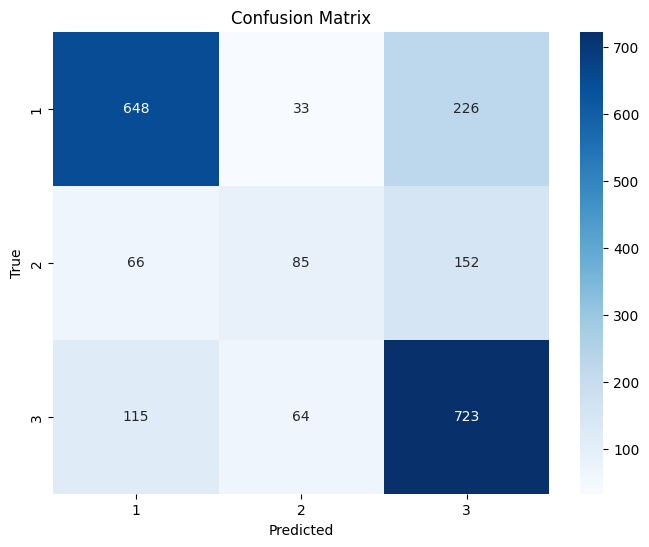

Accuracy for 1: 0.7144
Accuracy for 2: 0.2805
Accuracy for 3: 0.8016


In [136]:
model.eval()

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataloader
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Define your class labels

class_labels = ['1', '2', '3']
# class_labels = ['1', '2']

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, classes=class_labels)

# Calculate and print class accuracy
class_accuracies = class_accuracy(true_labels, predicted_labels, class_labels)

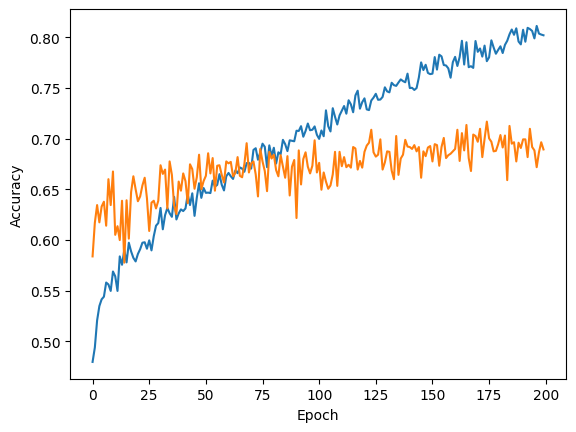

In [137]:
plot_accuracy_graphs(train_accuracies, val_accuracies)

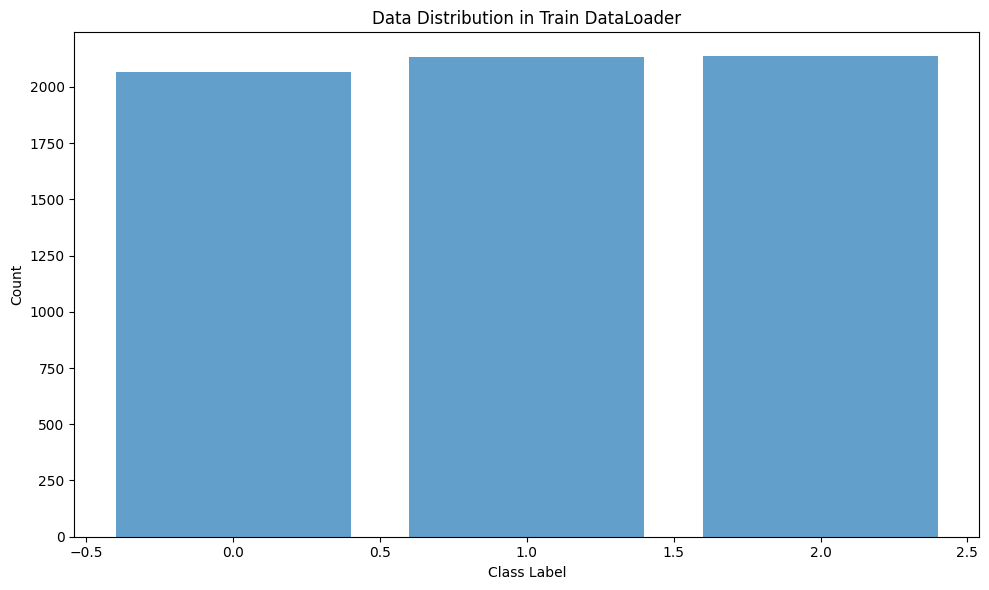

In [90]:
class_counts = {}

# Assuming that the labels are stored in the second element of each batch (change it if your labels are in a different location)
for data, labels in train_loader:
    labels = labels.numpy()
    for label in labels:
        label = int(label)  # Ensure the label is an integer
        if label not in class_counts:
            class_counts[label] = 1
        else:
            class_counts[label] += 1

# Extract unique class labels and their counts
class_labels = list(class_counts.keys())
class_label_counts = [class_counts[label] for label in class_labels]

# Create a bar graph to visualize the data distribution
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_label_counts, alpha=0.7)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Data Distribution in Train DataLoader')
plt.tight_layout()
plt.show()

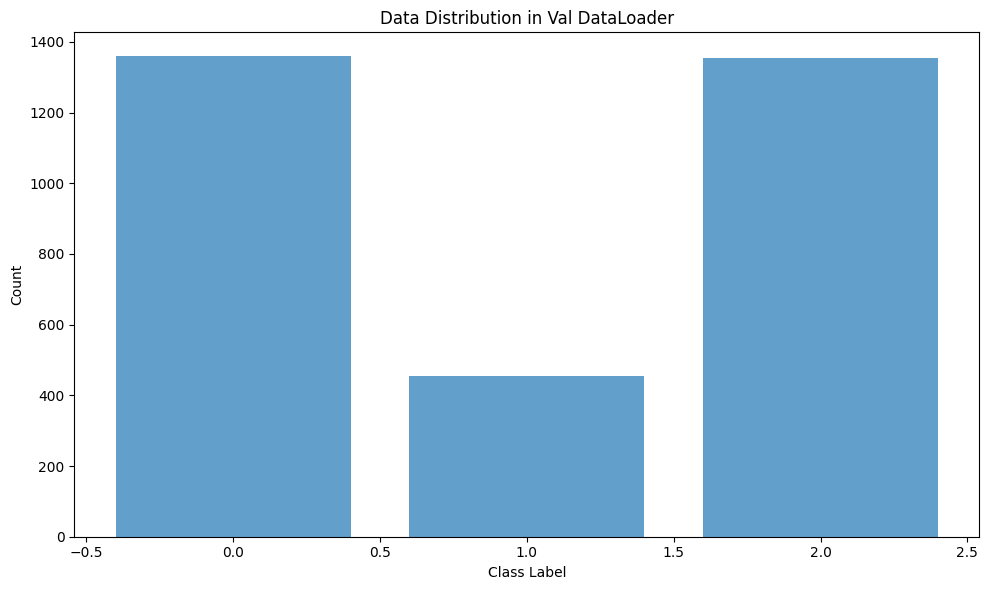

In [85]:
class_counts = {}

# Assuming that the labels are stored in the second element of each batch (change it if your labels are in a different location)
for data, labels in val_loader:
    labels = labels.numpy()
    for label in labels:
        label = int(label)  # Ensure the label is an integer
        if label not in class_counts:
            class_counts[label] = 1
        else:
            class_counts[label] += 1

# Extract unique class labels and their counts
class_labels = list(class_counts.keys())
class_label_counts = [class_counts[label] for label in class_labels]

# Create a bar graph to visualize the data distribution
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_label_counts, alpha=0.7)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Data Distribution in Val DataLoader')
plt.tight_layout()
plt.show()